<a href="https://colab.research.google.com/github/CzSadykov/taxi_orders_prediction/blob/main/Predicting%20a%20number%20of%20taxi%20orders%20(time%20series%20ML).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting a number of taxi orders (time series ML)

**Goal:** The customer wants to attract more drivers during peak periods.

**Task:** build a model to predict the number of taxi orders for the next hour. As part of this work, we will use **linear regression**, as well as models based on gradient boosting - **Light GBM** and **CatBoost**. Of these, we will choose the best one based on prediction quality metrics and training time.

**Data:** Historical data on taxi orders at airports. Features: number of orders (target feature), date/time.

**Initial requirements:**

* Period for resampling: 1 hour;
* The test sample percentage: 10% of the original data;
* The value of an *RMSE* metric on the test sample should not exceed 48.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots

from sklearn.model_selection import (train_test_split,
                                     TimeSeriesSplit,
                                     cross_val_score,
                                     RandomizedSearchCV)
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

## Preparing the data

Let's write a function to load data with date/time parsing as an index.

In [ ]:
def df_read(file_path):
    df = pd.read_csv(file_path, index_col=[0], parse_dates=[0])
    df = df.sort_index()
    print(df.info(), '\n')
    print('Количество дубликатов:', '\n', sum(df.duplicated()), '\n')
    print('Количество пропусков:', '\n', df.isna().sum(), '\n')
    return df

In [ ]:
df = df_read('https://code.s3.yandex.net/datasets/taxi.csv')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None 

Количество дубликатов: 
 26415 

Количество пропусков: 
 num_orders    0
dtype: int64 



We see that there are no gaps in the data - this is good. But at the same time, more than 90% of the data is read as duplicates (we assume that this is due to the peculiarities of indexing). Let's check if we have provided a chronological display of data using sorting.

In [ ]:
df.index.is_monotonic

True

Yes, we have. Now, according to the condition of the problem, we will resample the data in periods of 1 hour.

In [ ]:
df = df.resample('1H').sum()
display(df.head())
len(df)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


4416

Done! Now let's analyze our data.

## EDA

### Analyzing the data

Let's look at the exact range of our data.

In [ ]:
print(df.index.min())
print(df.index.max())

2018-03-01 00:00:00
2018-08-31 23:00:00


The period is March 1, 2018 to August 31, 2018. Now let's look at the main numerical characteristics of the target feature.

In [ ]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


We see the outliers. Let's see what dates they belong to.

In [ ]:
df.sort_values(by='num_orders', ascending=False).head(15)

,num_orders
datetime,
2018-08-20 02:00:00,462
2018-08-13 02:00:00,437
2018-08-27 02:00:00,408
2018-08-30 17:00:00,342
2018-08-27 04:00:00,295
2018-08-18 00:00:00,281
2018-08-26 00:00:00,281
2018-08-31 00:00:00,276
2018-08-13 01:00:00,273


We see that absolutely all anomalous values refer to August, the last month of our range. This means that the nature of the anomalies with a high probability may be an increase in the popularity of taxis as a trend.

Based on this, we will not remove these outliers before training the models.

#### Time series decomposition

Let's decompose the time series by trend, seasonality and residuals.

In [ ]:
df_decomp = seasonal_decompose(df)

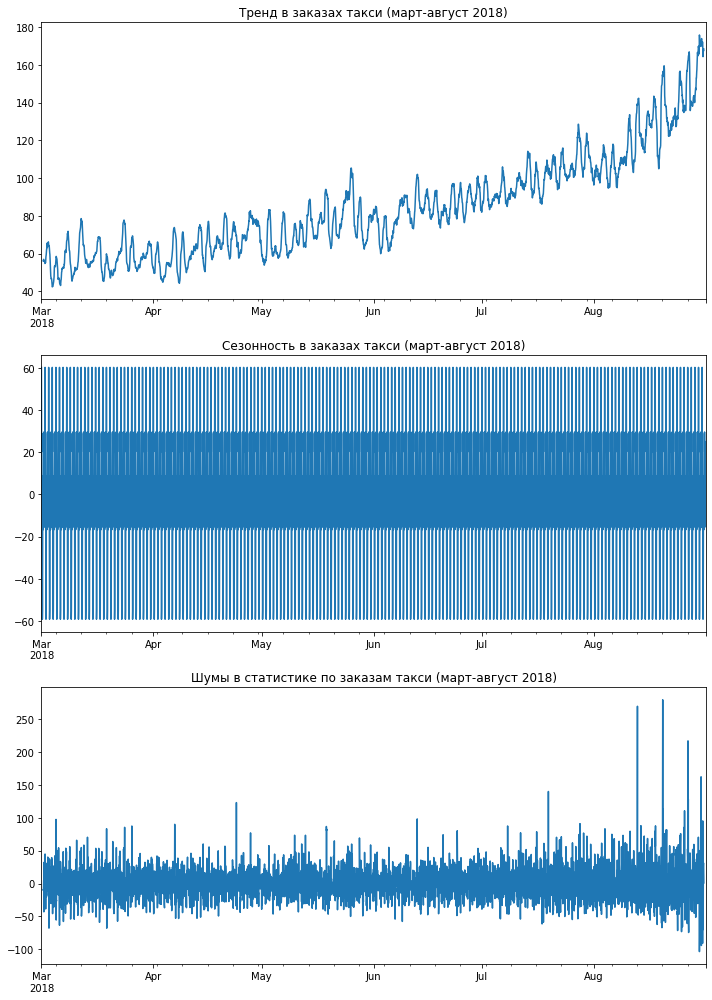

In [ ]:
plt.figure(figsize=(10,14))

plt.subplot(311)
df_decomp.trend.plot(ax=plt.gca());
plt.xlabel('');
plt.title('Тренд в заказах такси (март-август 2018)');

plt.subplot(312)
df_decomp.seasonal.plot(ax=plt.gca());
plt.xlabel('');
plt.title('Сезонность в заказах такси (март-август 2018)');

plt.subplot(313)
df_decomp.resid.plot(ax=plt.gca());
plt.xlabel('');
plt.title('Шумы в статистике по заказам такси (март-август 2018)');

plt.tight_layout()

We see that the number of orders from March to August is really growing smoothly. At the same time, the data do not yet allow us to detect seasonality.

Let's try to take slices by days, weeks and months.

##### Срез по дням

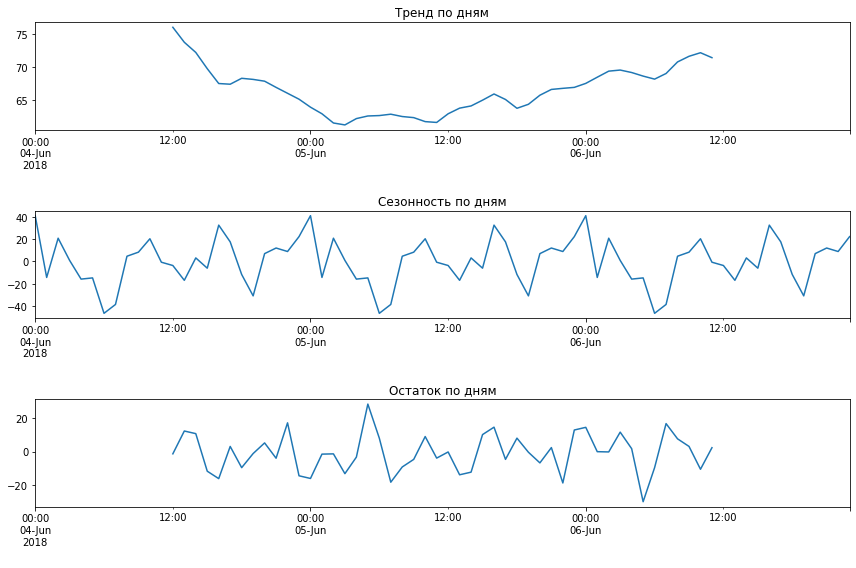

In [ ]:
df_day = df['2018-06-04':'2018-06-06']
df_day = seasonal_decompose(df_day)

plt.figure(figsize=(12,8))
plt.subplot(311);
df_day.trend.plot();
plt.title('Тренд по дням');
plt.xlabel(' ');

plt.subplot(312);
df_day.seasonal.plot();
plt.title('Сезонность по дням');
plt.xlabel(' ');

plt.subplot(313);
df_day.resid.plot();
plt.title('Остаток по дням');
plt.xlabel(' ');

plt.tight_layout()

But during the day we see the seasonality of orders!

* Peaks around **10:00, 16:00 and 00:00**. This pattern is repeated every day.
* Trend and residuals are poorly interpreted.

Let's look at the seasonality of another cut.

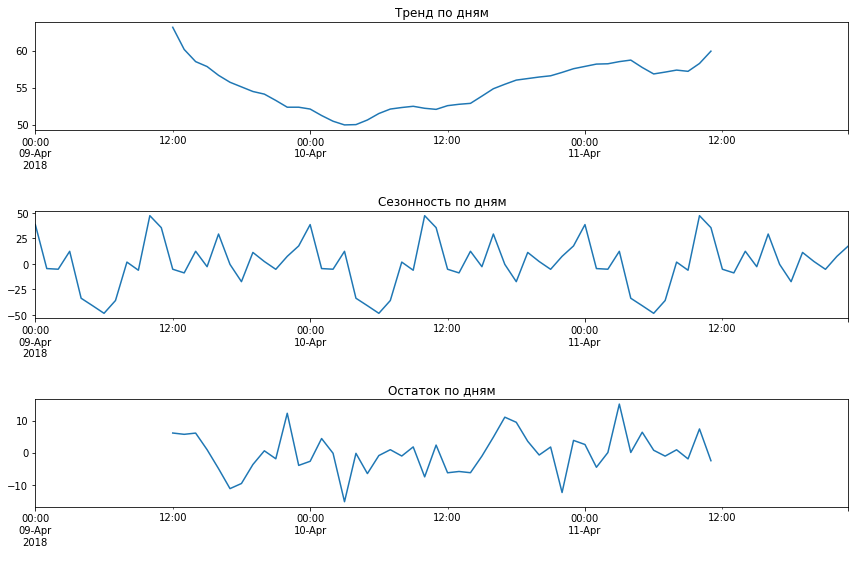

In [ ]:
df_day = df['2018-04-09':'2018-04-11']
df_day = seasonal_decompose(df_day)

plt.figure(figsize=(12,8))
plt.subplot(311);
df_day.trend.plot();
plt.title('Тренд по дням');
plt.xlabel(' ')

plt.subplot(312);
df_day.seasonal.plot();
plt.title('Сезонность по дням');
plt.xlabel(' ')

plt.subplot(313);
df_day.resid.plot();
plt.title('Остаток по дням');
plt.xlabel(' ')

plt.tight_layout()

The trend and seasonality look exactly the same here. Great.

Now let's look at the weekly seasonality.

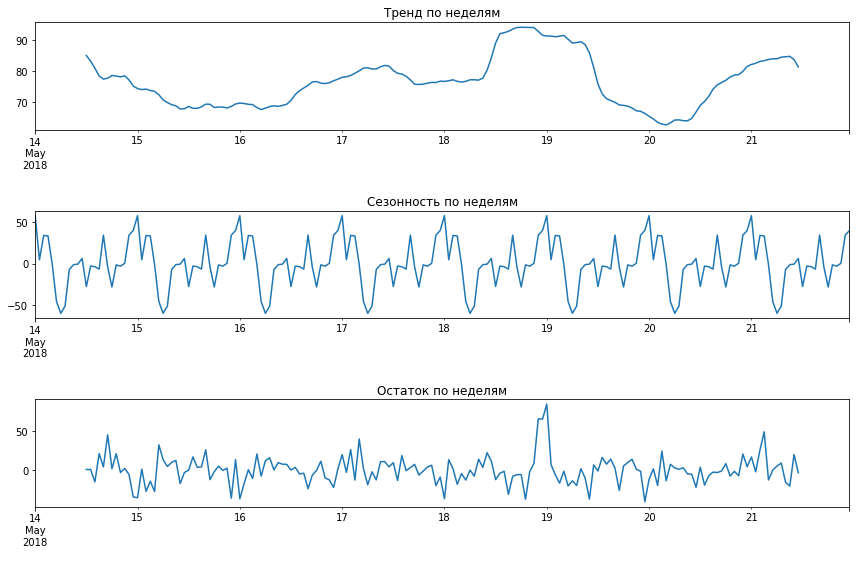

In [ ]:
df_week = df.resample('1D').sum()
df_week = df['2018-05-14':'2018-05-21']
df_week = seasonal_decompose(df_week)

plt.figure(figsize=(12, 8))

plt.subplot(311);
df_week.trend.plot(ax=plt.gca());
plt.title('Тренд по неделям');
plt.xlabel(' ')

plt.subplot(312);
df_week.seasonal.plot(ax=plt.gca());
plt.title('Сезонность по неделям');
plt.xlabel(' ')

plt.subplot(313);
df_week.resid.plot(ax=plt.gca());
plt.title('Остаток по неделям');
plt.xlabel(' ')

plt.tight_layout()


In weekly seasonality, we see the same peaks at the beginning of the day (about 00:00), when approaching noon (about 10:30) and before the evening period (about 16:00). Thus, **weekly seasonality reflects daily seasonality**.

The trend and residuals are non-interpretable.

Let's look at another cut.

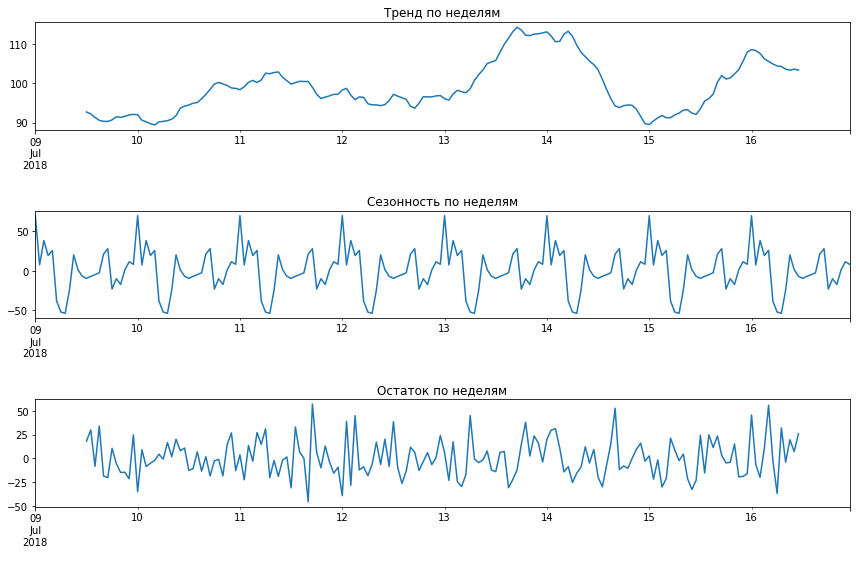

In [ ]:
df_week = df['2018-07-09':'2018-07-16']
df_week = seasonal_decompose(df_week)

plt.figure(figsize=(12,8));

plt.subplot(311);
df_week.trend.plot(ax=plt.gca());
plt.title('Тренд по неделям');
plt.xlabel(' ')

plt.subplot(312);
df_week.seasonal.plot(ax=plt.gca());
plt.title('Сезонность по неделям');
plt.xlabel(' ')

plt.subplot(313);
df_week.resid.plot(ax=plt.gca());
plt.title('Остаток по неделям');
plt.xlabel(' ')

plt.tight_layout()

Same picture here!

Now let's evaluate the seasonality by months.

##### Monthly seasonality

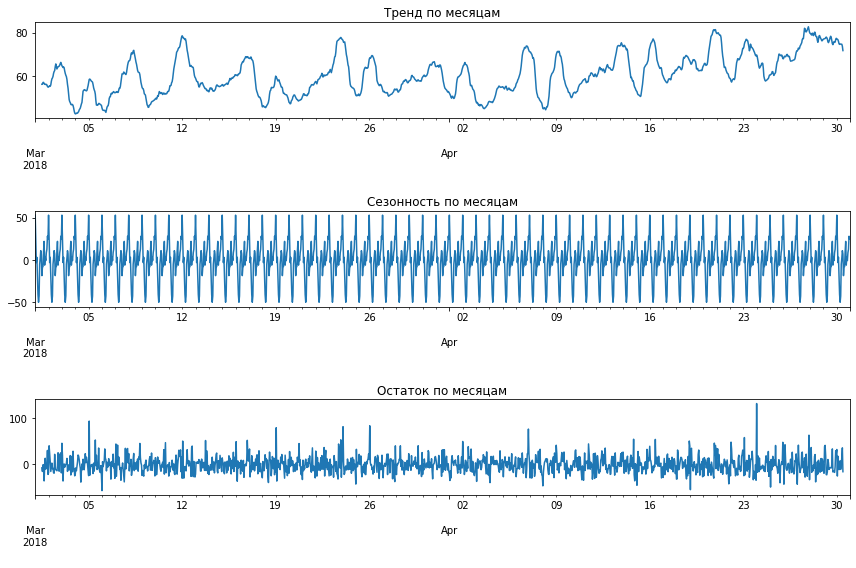

In [ ]:
df_months = df.resample('1W').sum()
df_months = df['2018-03-01':'2018-04-30']
df_months = seasonal_decompose(df_months)

plt.figure(figsize=(12,8))

plt.subplot(311);
df_months.trend.plot(ax=plt.gca());
plt.title('Тренд по месяцам');
plt.xlabel(' ');

plt.subplot(312);
df_months.seasonal.plot(ax=plt.gca());
plt.title('Сезонность по месяцам');
plt.xlabel(' ')

plt.subplot(313);
df_months.resid.plot(ax=plt.gca());
plt.title('Остаток по месяцам');
plt.xlabel(' ');

plt.tight_layout()

We see that there is no seasonality by months as such - it only reflects the same daily seasonality that we have identified.

Let's check it in another section.

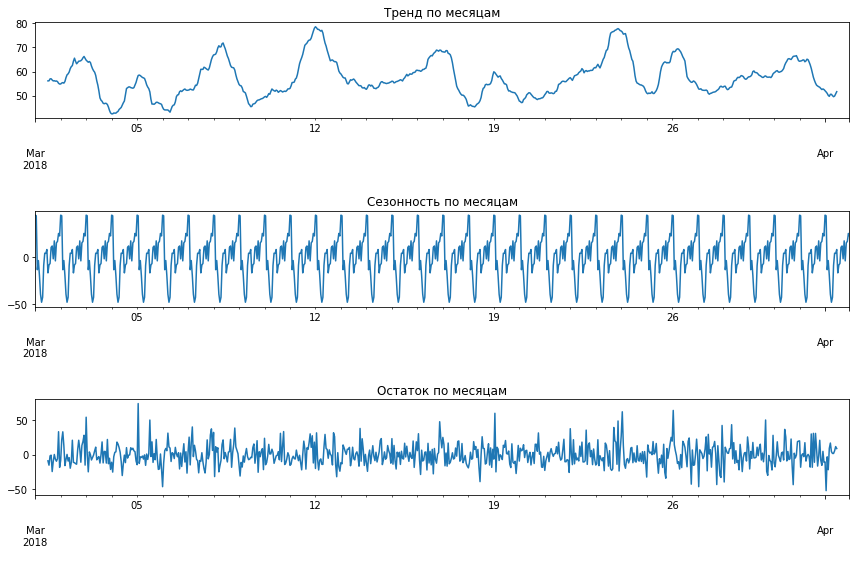

In [ ]:
df_months = df['2018-03-01':'2018-04-01']
df_months = seasonal_decompose(df_months)

plt.figure(figsize=(12, 8))
plt.subplot(311);
df_months.trend.plot(ax=plt.gca());
plt.title('Тренд по месяцам');
plt.xlabel(' ');

plt.subplot(312);
df_months.seasonal.plot(ax=plt.gca());
plt.title('Сезонность по месяцам');
plt.xlabel(' ');

plt.subplot(313);
df_months.resid.plot(ax=plt.gca());
plt.title('Остаток по месяцам');
plt.xlabel(' ');

plt.tight_layout()

Same picture here.

Now let's analyze the process by making the time series more stationary. To do this, we study the differences in the time series and their characteristics.

#### Analyzing the differences in time series

In [ ]:
df_shifted = df.shift(1, fill_value=0) - df

df_shifted['mean'] = df_shifted['num_orders'].rolling(3).mean()
df_shifted['std'] = df_shifted['num_orders'].rolling(3).std()

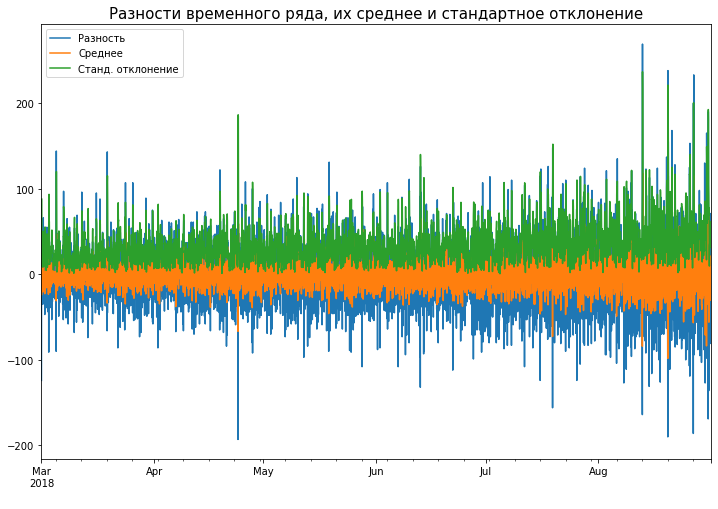

In [ ]:
plt.figure(figsize=(12,8));

df_shifted.plot(ax=plt.gca());
plt.title('Разности временного ряда, их среднее и стандартное отклонение', fontsize=15)
plt.legend(['Разность', 'Среднее', 'Станд. отклонение'])
plt.xlabel(' ');

We see that the distribution basically does not change in the process. Let's check the time series for stationarity using the Dickey-Fuller test.

In [ ]:
st_test = adfuller(df['num_orders'], regression='ctt')

if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')

Наш ряд стационарный


The series are stationary, indeed.

Let's try to decompose our differences by trend, seasonality and residuals.

In [ ]:
df_shifted_ord = seasonal_decompose(df_shifted['num_orders'])

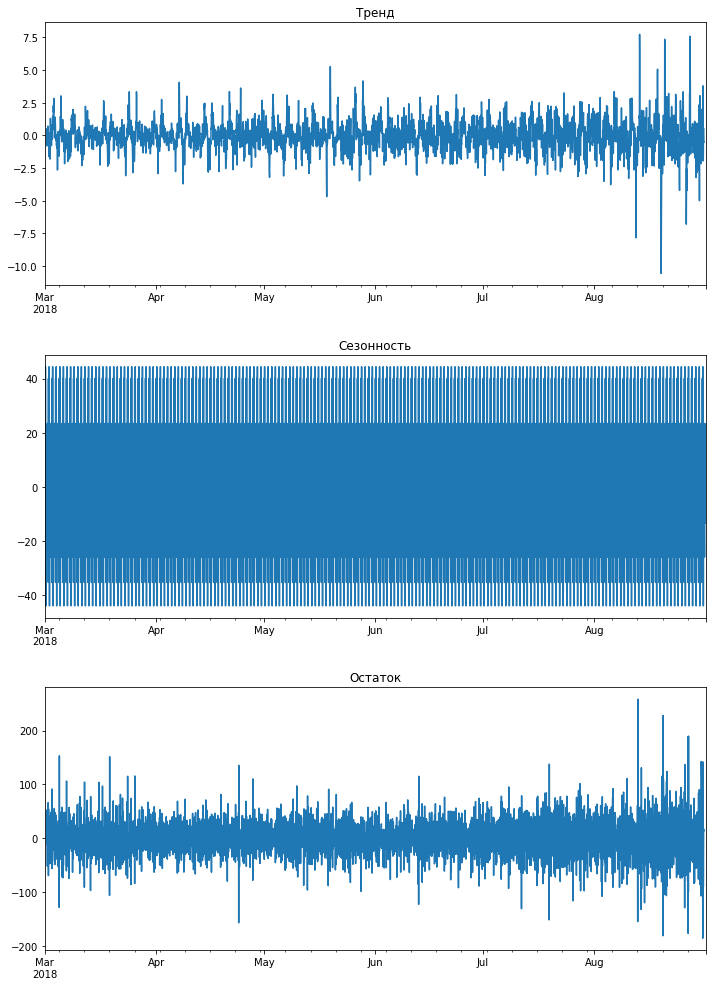

In [ ]:
plt.figure(figsize=(10,14))

plt.subplot(311)
df_shifted_ord.trend.plot(ax=plt.gca());
plt.title('Тренд');
plt.xlabel(' ');

plt.subplot(312)
df_shifted_ord.seasonal.plot(ax=plt.gca());
plt.title('Сезонность');
plt.xlabel(' ');

plt.subplot(313)
df_shifted_ord.resid.plot(ax=plt.gca());
plt.title('Остаток');
plt.xlabel(' ');

plt.tight_layout();

The trend reflects fluctuations in the mean of the differences in the time series, seasonality and residuals are still uninterpretable.

Let's evaluate the slices by daily and weekly measures.

##### Daily

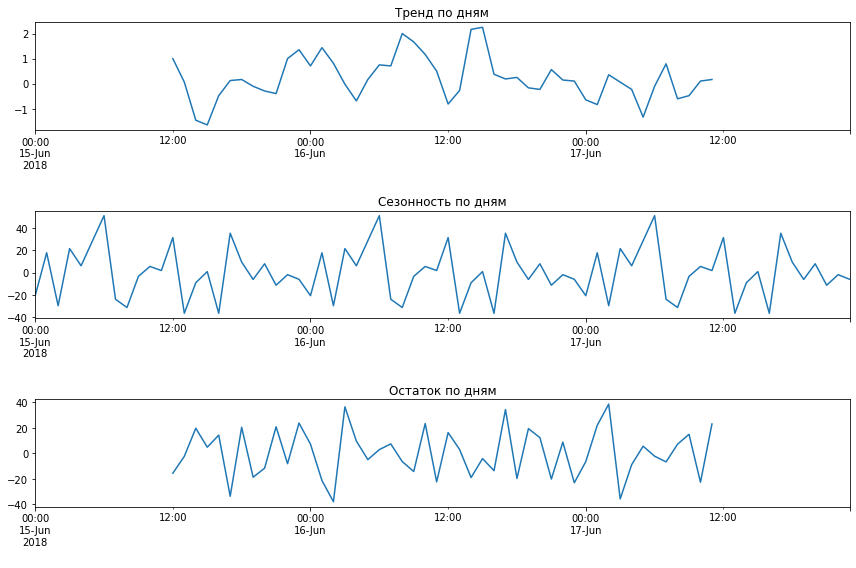

In [ ]:
df_shifted_day = df_shifted['2018-06-15':'2018-06-17']
df_shifted_day = seasonal_decompose(df_shifted_day['num_orders'])

plt.figure(figsize=(12, 8))

plt.subplot(311)
df_shifted_day.trend.plot(ax=plt.gca());
plt.title('Тренд по дням');
plt.xlabel(' ');

plt.subplot(312)
df_shifted_day.seasonal.plot(ax=plt.gca());
plt.title('Сезонность по дням');
plt.xlabel(' ');

plt.subplot(313)
df_shifted_day.resid.plot(ax=plt.gca());
plt.title('Остаток по дням');
plt.xlabel(' ');

plt.tight_layout();

Decomposing the differences for each hour and examining the seasonality for 2 days shows us that the sharpest spikes in orders occur around 1:00 am, 3:00 am, 5:00 am, 12:00 pm, 2:00 pm, and 4:00 pm. Thus, **3 large bursts of orders every 2 hours, starting at 1am and noon**. The trend and residuals are uninterpretable.

Let's look at other dates for the sake of interest.

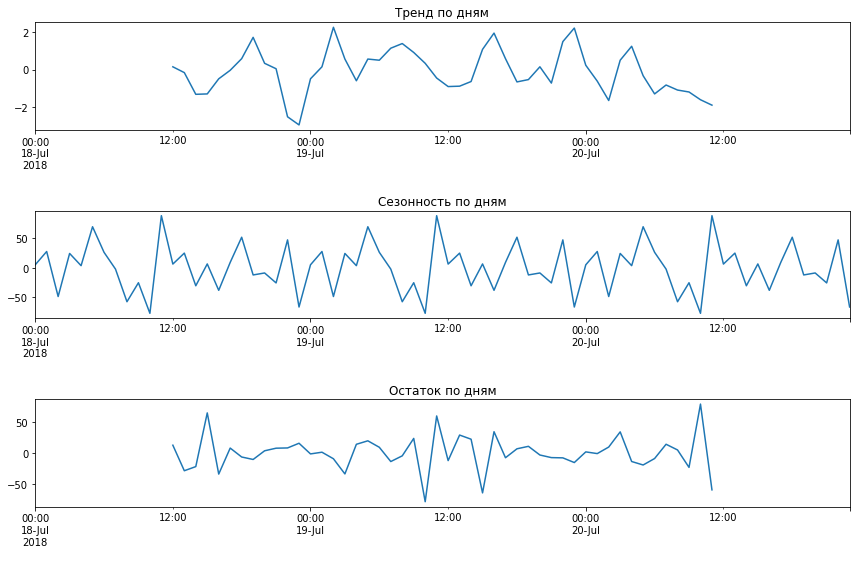

In [ ]:
df_shifted_day = df_shifted['2018-07-18':'2018-07-20']
df_shifted_day = seasonal_decompose(df_shifted_day['num_orders'])

plt.figure(figsize=(12, 8))

plt.subplot(311)
df_shifted_day.trend.plot(ax=plt.gca());
plt.title('Тренд по дням');
plt.xlabel(' ');

plt.subplot(312)
df_shifted_day.seasonal.plot(ax=plt.gca());
plt.title('Сезонность по дням');
plt.xlabel(' ');

plt.subplot(313)
df_shifted_day.resid.plot(ax=plt.gca());
plt.title('Остаток по дням');
plt.xlabel(' ');

plt.tight_layout();

There is a similar picture here: especially sharp bursts occur at periods around 1:00, 3:30, 5:30, 11:30 and 17:30.

Let's take a look at the decomposition by weeks.

##### Weekly

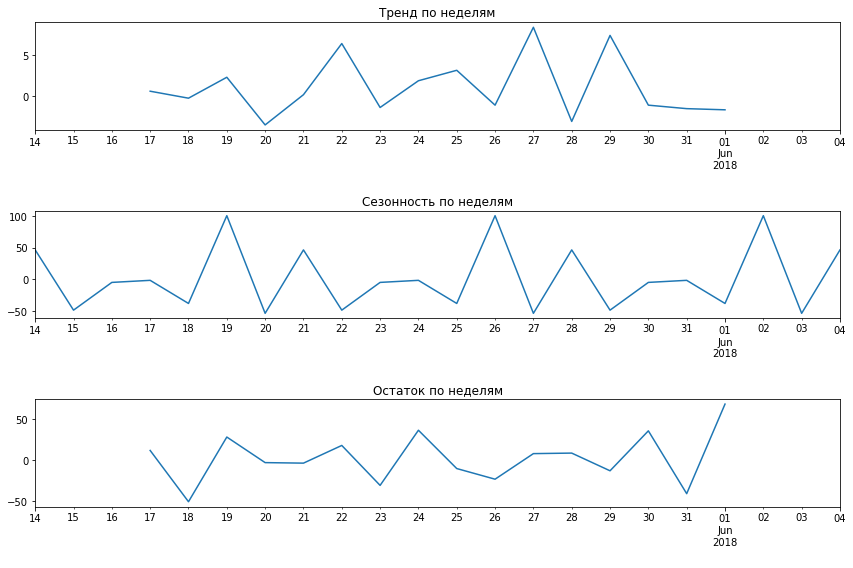

In [ ]:
df_shifted_week = df_shifted['2018-05-14':'2018-06-04'].resample('1D').sum()
df_shifted_week = seasonal_decompose(df_shifted_week['num_orders'])

plt.figure(figsize=(12, 8))

plt.subplot(311)
df_shifted_week.trend.plot(ax=plt.gca());
plt.title('Тренд по неделям');
plt.xlabel(' ');

plt.subplot(312)
df_shifted_week.seasonal.plot(ax=plt.gca());
plt.title('Сезонность по неделям');
plt.xlabel(' ');

plt.subplot(313)
df_shifted_week.resid.plot(ax=plt.gca());
plt.title('Остаток по неделям');
plt.xlabel(' ');

plt.tight_layout();

We see surges in orders every Monday (May 14, May 21, May 28, June 4) and every Saturday (May 19, May 26, June 2). **Day of the week is important!**

But let's look at a cross-section of other weeks for verification.

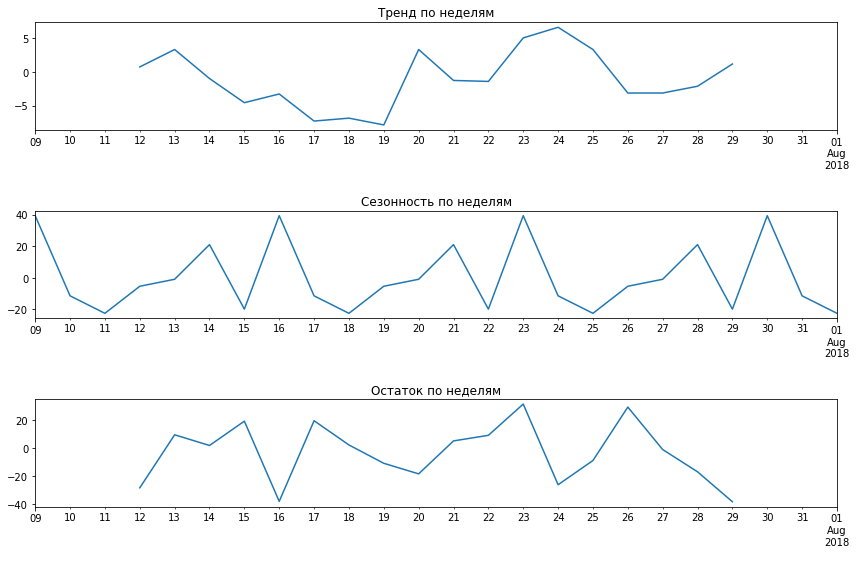

In [ ]:
df_shifted_week = df_shifted['2018-07-09':'2018-08-01'].resample('1D').sum()
df_shifted_week = seasonal_decompose(df_shifted_week['num_orders'])

plt.figure(figsize=(12, 8))

plt.subplot(311)
df_shifted_week.trend.plot(ax=plt.gca());
plt.title('Тренд по неделям');
plt.xlabel(' ');

plt.subplot(312)
df_shifted_week.seasonal.plot(ax=plt.gca());
plt.title('Сезонность по неделям');
plt.xlabel(' ');

plt.subplot(313)
df_shifted_week.resid.plot(ax=plt.gca());
plt.title('Остаток по неделям');
plt.xlabel(' ');

plt.tight_layout();

Likewise! Order surges occur on Mondays (July 9, July 16, July 23, July 30) and Saturdays (July 14, July 21, July 28).

The day of the week can serve as an important predictor in our models.

### Feature preprocessing and feature engineering

Based on the analysis of the decomposition of the time series and the differences, we will create additional features, taking periods of an hour, a day, and a day of the week.

In [ ]:
df['hour'] = df.index.hour
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek

Let's study autocorrelation to see if we need to create additional lag features. Considering that we've found seasonality during the day and days of the week, the likelihood is kinda high.

Let's build an autocorrelation graph for one week (168 observations for 1 hour).

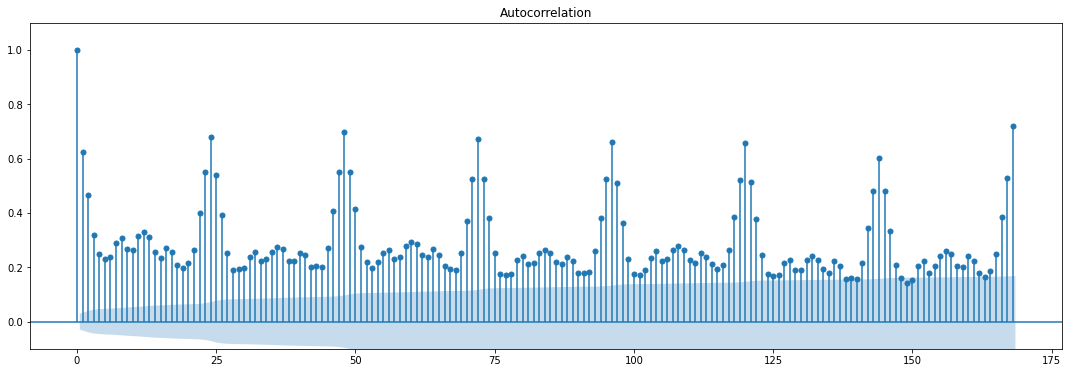

In [ ]:
fig = tsaplots.plot_acf(df['num_orders'].resample('1H').sum(),lags=168)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show()

We see that a high autocorrelation in observations is indeed observed every 24 hours. In this case, we take into account the weekly period in our training features, creating 168 lags. It also makes sense to create a rolling average based on the daily value of orders.

Let's create a function to enrich our features with additional ones.

In [ ]:
def make_new_features(df, target, lags_size, rolling_mean_size):

    for i in range(1, lags_size + 1):
        df[f'lag_{i}'] = df[target].shift(i)

    df['rolling'] = df[target].shift(1).rolling(rolling_mean_size).mean()
    df = df.dropna()

    return df

In [ ]:
df = make_new_features(df, 'num_orders', 168, 24)

Now we extract the target feature.

In [ ]:
features = df.drop(columns='num_orders')
target = df['num_orders']

Now let's prepare samples for training models and final testing. The 10% share of the test sample is taken due to our initial requirements.

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            shuffle=False,
                                                                            test_size=0.1)

print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(3823, 172)
(3823,)
(425, 172)
(425,)


Great, the samples were prepared in the right proportion. All our variables contain numerical values, but they differ only by 1-2 orders (the number of orders per hour is usually several hundred, days and hours are measured in units/tens). Therefore, we will not scale them.

We can start training models.

## Fitting the models

When training models, we will use cross-validation for time series (```TimeSeriesSplit```) on 5 blocks. For linear regression we'll use the ordinary cross-validation, for LightGBM and CatBoost models we'll use cross-validation with randomized hyperparameter tuning (```RandomizedSearchCV```).

#### Linear regression

In [ ]:
%%time

lr_model = LinearRegression()
lr_model.fit(features_train, target_train)

CPU times: user 94.2 ms, sys: 77 ms, total: 171 ms
Wall time: 190 ms


LinearRegression()

In [ ]:
%%time

tscv = TimeSeriesSplit(n_splits=5)

lr_rmse = cross_val_score(lr_model,
                          features_train,
                          target_train,
                         cv=tscv,
                         scoring='neg_root_mean_squared_error').mean()

print(f'Значение RMSE для линейной регрессии составляет: {-lr_rmse:.3f}')

Значение RMSE для линейной регрессии составляет: 22.694
CPU times: user 569 ms, sys: 1.28 s, total: 1.85 s
Wall time: 1.81 s


We fix the time of fitting and RMSE, then we move on to Light GBM.

#### LightGBM

To select the best model, we use cross-validation on 5 blocks with randomized tuning of hyperparameters (```RandomizedSearchCV```).

In [ ]:
%%time

RANDOM_STATE = 11235

lgb_model = LGBMRegressor(random_state=RANDOM_STATE, n_jobs=2)

param_grid = {'learning_rate':np.arange(0.1, 1, 0.1),
             'n_estimators':np.arange(1, 101, 5),
              'max_depth':np.arange(1,25, 3),
             'num_leaves':np.arange(1, 101, 5)}

lgb_random = RandomizedSearchCV(lgb_model,
                                param_distributions=param_grid,
                                cv=tscv,
                                verbose=2,
                                random_state=RANDOM_STATE,
                                n_iter=50,
                                scoring='neg_root_mean_squared_error')

lgb_random.fit(features_train, target_train)

LightGBM training with randomized hyperparameter fitting and cross-validation for time series on 5 blocks took 2 minutes and 8 seconds.

Let's look at the best hyperparameters and model results.

In [ ]:
%%time

print(f'Лучшая модель LGBM получается при следующих гиперпараметрах: {lgb_random.best_params_} \n')
print(f'Лучшее значение RMSE модели LGBM составляет: {-lgb_random.best_score_:.3f} \n',)

Лучшая модель LGBM получается при следующих гиперпараметрах: {'num_leaves': 71, 'n_estimators': 81, 'max_depth': 4, 'learning_rate': 0.1} 

Лучшее значение RMSE модели LGBM составляет: 22.831 

CPU times: user 838 µs, sys: 115 µs, total: 953 µs
Wall time: 618 µs


Surprisingly, the RMSE of the LGBM model turned out to be even higher than that of the linear regression.

Now let's test the CatBoost model using a similar technique.

#### CatBoost

In [ ]:
%%time

cb_model = CatBoostRegressor(random_state=RANDOM_STATE)

cb_random = RandomizedSearchCV(cb_model,
                                param_distributions=param_grid,
                                cv=tscv,
                                verbose=2,
                                random_state=RANDOM_STATE,
                                n_iter=50,
                                scoring='neg_root_mean_squared_error')

cb_random.fit(features_train, target_train)

Training CatBoost with randomized hyperparameter tuning and cross-validation on 5 blocks took 9 minutes and 7 seconds. Let's look at the quality of the model and its hyperparameters.

In [ ]:
%%time

print(f'Лучшая модель CatBoost получается при следующих гиперпараметрах: {cb_random.best_params_} \n')
print(f'Лучшее значение RMSE модели CatBoost составляет: {-cb_random.best_score_:.3f} \n',)

Лучшая модель CatBoost получается при следующих гиперпараметрах: {'num_leaves': 31, 'n_estimators': 61, 'max_depth': 1, 'learning_rate': 0.5} 

Лучшее значение RMSE модели CatBoost составляет: 23.429 

CPU times: user 203 µs, sys: 45 µs, total: 248 µs
Wall time: 183 µs


Linear regression outperformed the LightGBM and CatBoost models both in terms of learning speed and prediction quality.

### Comparing the models

Let's collect our metrics in a table.

In [ ]:
res_index = ['Линейная регрессия', 'Light GBM', 'CatBoost']

cols = ['Время обучения', 'Значение метрики RMSE']

res_data = [['1.81 сек', 22.694],
            ['2 мин 8 сек', 22.831],
           ['9 мин 7 мек', 23.429]]

results = pd.DataFrame(data = res_data, index=res_index, columns=cols)


display(results)

,Время обучения,Значение метрики RMSE
Линейная регрессия,1.81 сек,22.694
Light GBM,2 мин 8 сек,22.831
CatBoost,9 мин 7 мек,23.429


Linear regression outperformed all models both in terms of training time and the value of the RMSE metric. Therefore, we shall use it!

## Testing the best model

According to our initial requirements , in order to successfully pass the selection, the value of the RMSE metric on the test sample should not exceed 48.

In [ ]:
predictions = lr_model.predict(features_test)
test_rmse = mean_squared_error(target_test, predictions, squared=False)

print(f'Лучшее значение RMSE линейной регрессии на тестовой выборке составляет: {test_rmse:.3f} \n',)

Лучшее значение RMSE линейной регрессии на тестовой выборке составляет: 34.201 



Our RMSE value is **34.2**! The model comfortably settles in the range and successfully passes the test :)

But in conclusion we shall conduct a sanity check by comparing the final RMSE with predictions based on previous values of the time series.

### Sanity check

In [ ]:
predictions_previous = target_test.shift(1)
predictions_previous.iloc[0] = target_train.iloc[-1]

sanity_check_rmse = mean_squared_error(target_test, predictions_previous, squared=False)

print(f'При предсказаниях на основе предыдущего значения временного ряда \
 RMSE составляет: {sanity_check_rmse:.3f} \n',)

При предсказаниях на основе предыдущего значения временного ряда  RMSE составляет: 58.820 



Our model passes a sanity check successfully!

## Results

**Best Model**

Linear regression trained with cross-validation for 5-block time series in basically zero time. Final RMSE: 34.201.

Training and testing was carried out on the basis of features extended by 168 time lags (where each lag is 1 hour of observations) and a moving average taken for 24-hour windows.